In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
%tensorflow_version 2.x

In [3]:
import librosa as lib
import librosa.display as libdp

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [6]:
epl_sampling_rate, epl_mfcc = 44100, 50

In [7]:
data, sr = lib.load('/content/03-01-01-01-01-01-01.wav', sr = epl_sampling_rate)

In [8]:
mfcc = lib.feature.mfcc(data, sr = sr, n_mfcc=epl_mfcc)

In [9]:
mfcc.shape

(50, 285)

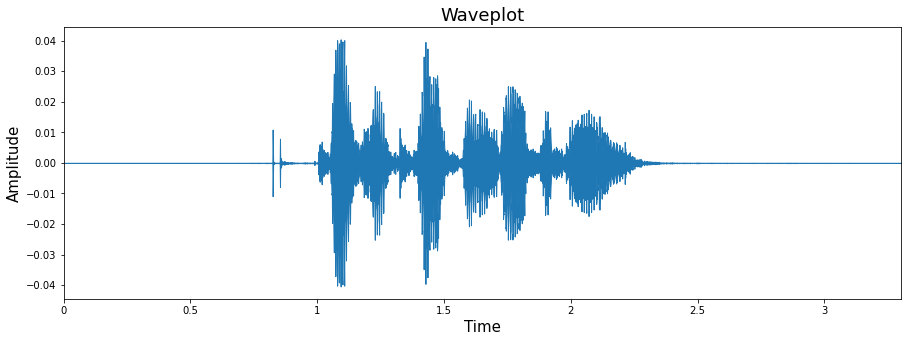

In [10]:
plt.figure(figsize=(15, 5))
libdp.waveplot(data, sr=sr)
plt.title("Waveplot", fontdict=dict(size=18))
plt.xlabel("Time", fontdict=dict(size=15))
plt.ylabel("Amplitude", fontdict=dict(size=15))
plt.show()

In [11]:
# from waveplot we can understand that a user speaks after 1 sec after start of recording and lasts upto ~2.3(2 sec and 300 ms).
# from this we can draw a conclusion that we need to process data of ~3sec but to be on safe side. I will allow user to give audio input of 4 sec.
# The problem here is i dont know right now how many mfcc to keep so that we can capture all imp features of audio but,
# acc to my instructor mfcc above 40 dont affect any significant change in predictions instead cause huge computational power.
# So i will follow his words and keep count of mfcc to 40.

In [12]:
# spectogram plot

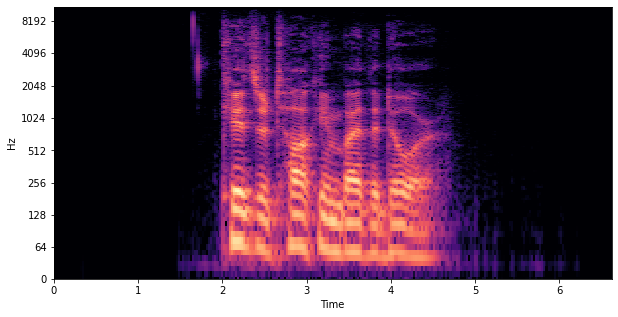

In [13]:
D = np.abs(lib.stft(data))
db = lib.amplitude_to_db(D,ref=np.max)

fig = plt.figure(figsize=(10, 5)) # This setups the figure
libdp.specshow(db, x_axis='time', y_axis='log')
plt.show()

In [14]:
# from spectogram we can notice that most of audio is of 64HZ, 128HZ and 256HZ and other frequencies may or may not occur.

In [15]:
# The time in wave plot is 3sec and in spectogram its 6 sec. I dont know why time jumped by twice.
# but If i want to guess then, this might because of sampling rate as it is twice of original one.
# If this reason is correct then why it didnt affected in waveplot ?
# If anyone knows exact reason please do mail me on : deepprajapati01@gmail.com

In [16]:
# at max 455 max mfcc feature are found in some audio. So I will keep maxLimit to 600.

In [17]:
maxLimit, nmfcc, samplingRate = 600, 40, 44100

In [18]:
def feature_extractor(loc, samplingRate, nmfcc):
  audio, sr_temp = lib.load(loc, sr = samplingRate)
  mfcc = lib.feature.mfcc(audio, sr = sr_temp, n_mfcc= nmfcc)

  pad_needed = maxLimit - mfcc.shape[1]
  feature = np.pad(mfcc, pad_width=((0,0), (0, pad_needed)))

  return [feature, int(loc.split('-')[2])]
  

In [19]:
from os import listdir
arr = listdir('/content/MyDrive/MyDrive/datasets/Audio')

In [20]:
audio_features = []

In [21]:
for folder in arr:
  for files in listdir('/content/MyDrive/MyDrive/datasets/Audio/' + folder):
    audio_features.append(feature_extractor('/content/MyDrive/MyDrive/datasets/Audio/' + folder + "/" + files, samplingRate, nmfcc))

In [22]:
df = pd.DataFrame(audio_features, columns=['feature', 'sentiment'])

In [23]:
df.head()

,feature,sentiment
0,"[[-855.3771, -855.3771, -855.3771, -855.3771, ...",1
1,"[[-850.3917, -850.4358, -850.4358, -850.4358, ...",1
2,"[[-842.93854, -843.2475, -850.22943, -853.3461...",1
3,"[[-849.7837, -848.8447, -848.5661, -847.72864,...",1
4,"[[-911.17584, -910.40533, -905.28296, -900.878...",2


In [24]:
# this dataframe will not have any NaN

In [25]:
# (1 = neutral, 2 = calm, 3 = happy, 4 = sad, 5 = angry, 6 = fearful, 7 = disgust, 8 = surprised)

In [26]:
# this step was introduced to solve issue at the last of this notebook
df['sentiment'] = df['sentiment'] - 1

In [27]:
# Updated emotions
# (0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised)

In [28]:
# check for distribution of the sentiments

In [29]:
df['sentiment'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [30]:
# np.arange(1, 9, 1)

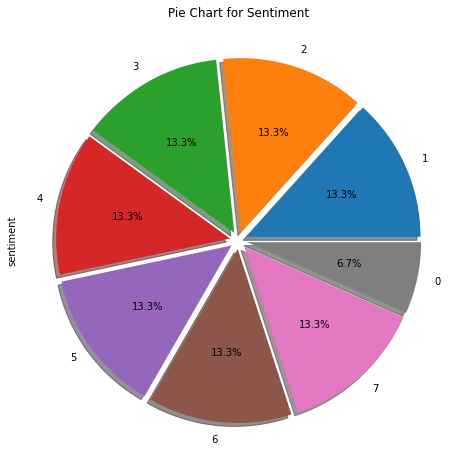

In [31]:
df['sentiment'].value_counts().plot.pie(explode=[0.05, 0.05,0.05,0.05, 0.05,0.05,0.05, 0.05], autopct='%1.1f%%', shadow=True, figsize=(8,8))
plt.title('Pie Chart for Sentiment')
plt.show()

In [32]:
# almost data is well distributed except class 0 i.e Neutral Sentiment

In [33]:
# save the dataframe for future use
df.to_csv('audio_mfcc.csv', index=False)

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
# shape of df is (1440,2)
# so the test size i must keep is either 0.3 or 0.2

In [36]:
X = np.array(df['feature'].tolist())
Y = np.array(df['sentiment'].tolist())

In [37]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split( X, Y,
                                                 test_size=0.2,
                                                 stratify= Y,
                                                 random_state = 2022)

In [38]:
Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape

((1152, 40, 600), (288, 40, 600), (1152,), (288,))

In [39]:
Xtrain[0].shape

(40, 600)

In [40]:
# as the independent variable is 2D array we need to reshape it

In [41]:
Xtrain = Xtrain.reshape((Xtrain.shape[0], nmfcc, maxLimit, 1))

In [42]:
Xtest = Xtest.reshape((Xtest.shape[0], nmfcc, maxLimit, 1))

In [43]:
Xtrain.shape

(1152, 40, 600, 1)

In [44]:
# Xtrain[:10]

In [45]:
# create model

In [46]:
model = tf.keras.models.Sequential()

In [47]:
model.add(tf.keras.layers.Conv2D(32, 3, input_shape=(nmfcc, maxLimit, 1), activation='relu'))

In [48]:
model.add(tf.keras.layers.MaxPool2D(2))

In [49]:
model.add(tf.keras.layers.Dropout(0.2))

In [50]:
model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))

In [51]:
model.add(tf.keras.layers.MaxPool2D(2))

In [52]:
model.add(tf.keras.layers.Dropout(0.2))

In [53]:
model.add(tf.keras.layers.Conv2D(128, 3, activation='relu'))

In [54]:
model.add(tf.keras.layers.MaxPool2D(2))

In [55]:
model.add(tf.keras.layers.Dropout(0.2))

In [56]:
model.add(tf.keras.layers.GlobalAveragePooling2D())

In [57]:
model.add(tf.keras.layers.Dense(256, activation='relu'))

In [58]:
model.add(tf.keras.layers.Dense(128, activation='relu'))

In [59]:
model.add(tf.keras.layers.Dense(64, activation='relu'))

In [60]:
model.add(tf.keras.layers.Dense(8, activation='softmax'))

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 598, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 299, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 299, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 297, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 148, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 148, 64)        0

In [62]:
# set the standards for training

In [63]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])

In [64]:
# train the model

In [65]:
# I ran in issue i.e the to_categorical is converting to different shape size from 8 to 9 (dont know why)
# the solution for this issue are
# 1.) Change the output neurons to 9 from 8
# 2.) dont use to_categorical and change the loss function to SparseCategoricalCrossentropy
# 3.) pass another argument num_classes=8 in to_catgorical in model.fit
# 4.) substract 1 from df['sentiment'] i.e reassign emotions a number 

In [66]:
history = model.fit(Xtrain, tf.keras.utils.to_categorical(Ytrain),
                    batch_size = 64,
                    epochs = 100,
                    validation_data = (Xtest, tf.keras.utils.to_categorical(Ytest)),
                    use_multiprocessing=True)

Epoch 1/100
18/18 [==============================] - 12s 131ms/step - loss: 2.1650 - accuracy: 0.1606 - val_loss: 2.0456 - val_accuracy: 0.1458
Epoch 2/100
18/18 [==============================] - 2s 101ms/step - loss: 2.0256 - accuracy: 0.1771 - val_loss: 1.9871 - val_accuracy: 0.1667
Epoch 3/100
18/18 [==============================] - 2s 102ms/step - loss: 1.9560 - accuracy: 0.2049 - val_loss: 1.9054 - val_accuracy: 0.2639
Epoch 4/100
18/18 [==============================] - 2s 102ms/step - loss: 1.9178 - accuracy: 0.2326 - val_loss: 1.8701 - val_accuracy: 0.2743
Epoch 5/100
18/18 [==============================] - 2s 102ms/step - loss: 1.9007 - accuracy: 0.2335 - val_loss: 1.8758 - val_accuracy: 0.2569
Epoch 6/100
18/18 [==============================] - 2s 103ms/step - loss: 1.8899 - accuracy: 0.2691 - val_loss: 1.8529 - val_accuracy: 0.2569
Epoch 7/100
18/18 [==============================] - 2s 102ms/step - loss: 1.8497 - accuracy: 0.2795 - val_loss: 1.8092 - val_accuracy: 0.329

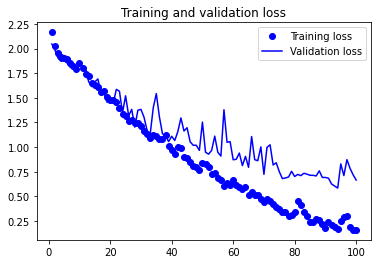

In [68]:
epochs = range(1, 101)
plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [69]:
# prediction part
Ypred = model.predict(Xtest)

In [70]:
Ypred = np.argmax(Ypred, axis = 1)

In [71]:
from sklearn.metrics import classification_report

In [72]:
print(classification_report(Ytest, Ypred))

              precision    recall  f1-score   support

           0       0.52      0.84      0.64        19
           1       0.90      0.92      0.91        39
           2       0.80      0.74      0.77        38
           3       0.73      0.42      0.53        38
           4       0.78      0.92      0.84        38
           5       0.80      0.72      0.76        39
           6       0.85      0.72      0.78        39
           7       0.79      0.97      0.87        38

    accuracy                           0.78       288
   macro avg       0.77      0.78      0.76       288
weighted avg       0.79      0.78      0.77       288



In [73]:
# save model
model.save('audio_model.h5')